In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

In [0]:
cd '/gdrive/My Drive/Colab Notebooks/Knight ML Assignment/Data/mydata'

/gdrive/My Drive/Colab Notebooks/Knight ML Assignment/Data/mydata


In [0]:
df=pd.read_csv('df1_train.csv')[['review_description','variety',]]

In [0]:
df.head()

,review_description,variety
0,"Vines planted on steep, terraced slopes around...",Rosé
1,The textured skin of russet apples and William...,White Blend
2,This bottling is still very young and will vas...,Syrah
3,Luzon's signature Best Buy red blends one-thir...,Red Blend
4,"Nicely balanced for dinner time, this dry wine...",Zinfandel


In [0]:
df['category_id']=df['variety'].factorize()[0]

In [0]:
category_id_df=df[['variety','category_id']].drop_duplicates().sort_values('category_id')

In [0]:
category_to_id = category_id_df.set_index('variety')['category_id'].to_dict()

In [0]:
id_to_category = category_id_df.set_index('category_id')['variety'].to_dict()

In [0]:
tfidf=TfidfVectorizer( sublinear_tf=True,min_df=10,norm='l2',ngram_range=(1,2),stop_words='english')

In [0]:
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
features = tfidf.fit_transform(df.review_description)

In [0]:
features.shape

(41319, 17798)

In [0]:
features=features.toarray()

In [0]:
labels=df.category_id

In [0]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for variety, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(variety))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bordeaux-style Red Blend':
  . Most correlated unigrams:
. bordeaux
. sample
  . Most correlated bigrams:
. black currant
. barrel sample
# 'Bordeaux-style White Blend':
  . Most correlated unigrams:
. sémillon
. botrytis
  . Most correlated bigrams:
. sémillon sauvignon
. sémillon blend
# 'Cabernet Franc':
  . Most correlated unigrams:
. cab
. franc
  . Most correlated bigrams:
. franc palate
. cab franc
# 'Cabernet Sauvignon':
  . Most correlated unigrams:
. cassis
. cab
  . Most correlated bigrams:
. flavors blackberries
. 100 cabernet
# 'Champagne Blend':
  . Most correlated unigrams:
. dosage
. champagne
  . Most correlated bigrams:
. high dosage
. dry champagne
# 'Chardonnay':
  . Most correlated unigrams:
. buttered
. chardonnay
  . Most correlated bigrams:
. tropical fruit
. buttered toast
# 'Gamay':
  . Most correlated unigrams:
. nouveau
. beaujolais
  . Most correlated bigrams:
. cherry fruits
. cru wine
# 'Gewürztraminer':
  . Most correlated unigrams:
. lychee
. gewürzt

Started Training LinearSVC
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Completed Training LinearSVC
Started Training MultinomialNB
Completed Training MultinomialNB


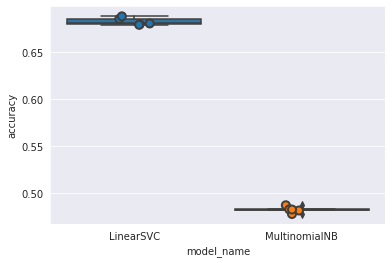

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [
    LinearSVC(verbose=1),
    MultinomialNB(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  print("Started Training {}".format(model_name))
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
  print("Completed Training {}".format(model_name))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [0]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC        0.682931
MultinomialNB    0.482296
Name: accuracy, dtype: float64

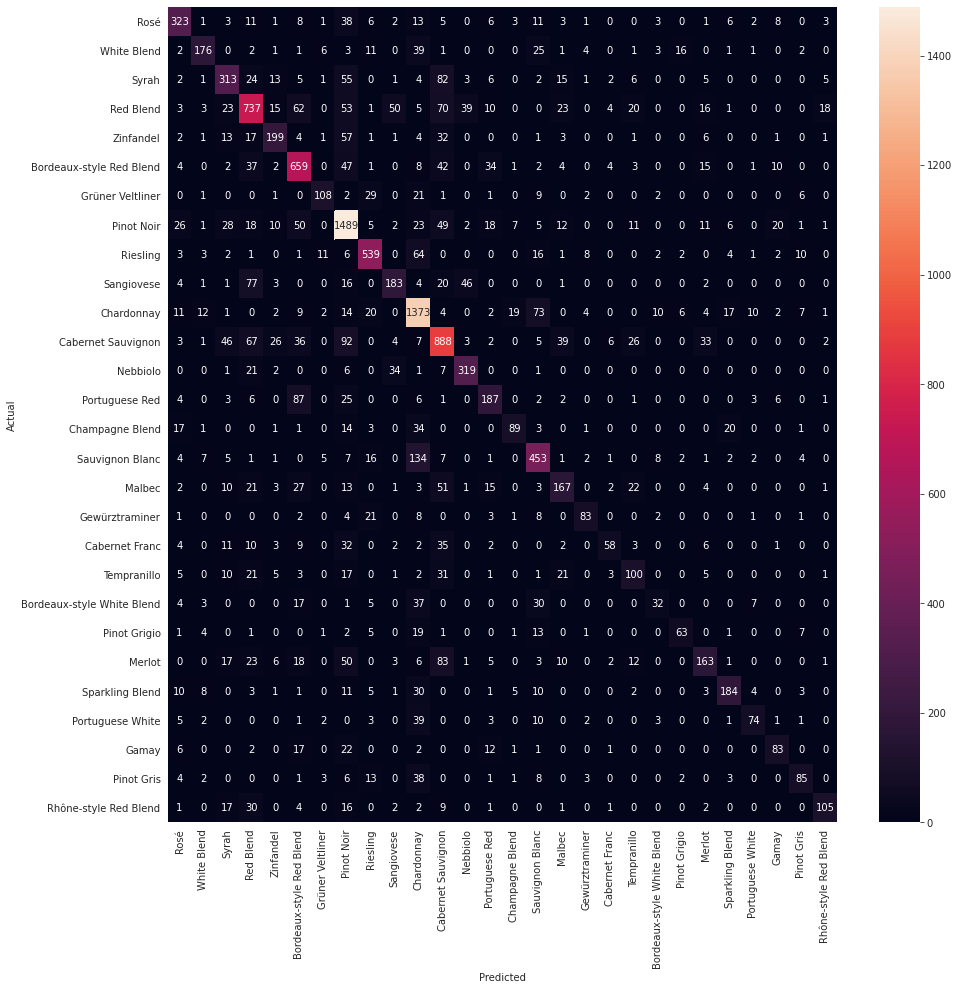

In [0]:
from sklearn.model_selection import train_test_split
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.variety.values, yticklabels=category_id_df.variety.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [0]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 100:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['variety', 'review_description']])
      print('')

'Sauvignon Blanc' predicted as 'Chardonnay' : 134 examples.


,variety,review_description
34120,Sauvignon Blanc,"Tart, tangy lemon flavor meets green apple and..."
33868,Sauvignon Blanc,"Aromas of caramel, toffee and lemon zest set t..."
23942,Sauvignon Blanc,From the intensely steep Monts Damnés vineyard...
23042,Sauvignon Blanc,Wheaty white-fruit aromas lack pop and clarity...
35276,Sauvignon Blanc,"Aromas of herb, grass, pear and citrus lead to..."
...,...,...
30596,Sauvignon Blanc,Citrusy aromas suggest white grapefruit. Plump...
20788,Sauvignon Blanc,Aged half in stainless and half in new French ...
6314,Sauvignon Blanc,"This is on the full-bodied side, quite ripe an..."
21965,Sauvignon Blanc,"This is dry, but lushly fruity, with sour-cand..."


In [0]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bordeaux-style Red Blend':
  . Top unigrams:
       . bordeaux
       . merlot
  . Top bigrams:
       . bordeaux blend
       . black currant
# 'Bordeaux-style White Blend':
  . Top unigrams:
       . botrytis
       . sémillon
  . Top bigrams:
       . sémillon sauvignon
       . sémillon blend
# 'Cabernet Franc':
  . Top unigrams:
       . franc
       . loire
  . Top bigrams:
       . cab franc
       . cabernet franc
# 'Cabernet Sauvignon':
  . Top unigrams:
       . cabernet
       . cab
  . Top bigrams:
       . pure cabernet
       . blended merlot
# 'Champagne Blend':
  . Top unigrams:
       . champagne
       . dosage
  . Top bigrams:
       . dry champagne
       . crisp steely
# 'Chardonnay':
  . Top unigrams:
       . chardonnay
       . chard
  . Top bigrams:
       . blanc blancs
       . yellow fruits
# 'Gamay':
  . Top unigrams:
       . beaujolais
       . cherry
  . Top bigrams:
       . cru wine
       . cherry fruits
# 'Gewürztraminer':
  . Top unigrams:
      

In [0]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['variety'].unique()))

                            precision    recall  f1-score   support

                      Rosé       0.72      0.70      0.71       459
               White Blend       0.77      0.59      0.67       296
                     Syrah       0.62      0.57      0.60       546
                 Red Blend       0.65      0.64      0.65      1153
                 Zinfandel       0.67      0.58      0.62       345
  Bordeaux-style Red Blend       0.64      0.75      0.69       876
          Grüner Veltliner       0.77      0.59      0.67       183
                Pinot Noir       0.71      0.83      0.76      1795
                  Riesling       0.79      0.80      0.79       676
                Sangiovese       0.64      0.51      0.57       358
                Chardonnay       0.71      0.86      0.78      1603
        Cabernet Sauvignon       0.63      0.69      0.66      1286
                  Nebbiolo       0.77      0.81      0.79       392
            Portuguese Red       0.60      0.56

In [0]:
from joblib import dump,load

In [0]:
dump(tfidf,'tfidf_review_description.joblib')

['tfidf_review_description.joblib']

In [0]:
dump(model,'svm_review_description.joblib')

['svm_review_description.joblib']